In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [17]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [18]:
merged_data = transactions.merge(customers, on='CustomerID')

customer_profile = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'TransactionDate': 'max'
}).reset_index()

current_date = pd.to_datetime('2025-01-27')
customer_profile['Recency'] = (current_date - pd.to_datetime(customer_profile['TransactionDate'])).dt.days

customer_profile.rename(columns={'TotalValue': 'Total_Spending', 'TransactionID': 'Transaction_Count'}, inplace=True)

In [19]:
features = customer_profile[['Total_Spending', 'Transaction_Count', 'Recency']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [20]:
range_n_clusters = range(2, 11)  # Testing from 2 to 10 clusters

results = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    customer_profile['Cluster'] = kmeans.fit_predict(scaled_features)
    
    # Calculate metrics
    db_index = davies_bouldin_score(scaled_features, customer_profile['Cluster'])
    silhouette_avg = silhouette_score(scaled_features, customer_profile['Cluster'])
    
    results.append((n_clusters, db_index, silhouette_avg))
    print(f'Clusters: {n_clusters}, DB Index: {db_index}, Silhouette Score: {silhouette_avg}')

Clusters: 2, DB Index: 1.0424071173923852, Silhouette Score: 0.3520146906810545
Clusters: 3, DB Index: 0.8802397042171065, Silhouette Score: 0.3836061137229286
Clusters: 4, DB Index: 0.9996029399201981, Silhouette Score: 0.32138303181756434
Clusters: 5, DB Index: 1.2013446511282069, Silhouette Score: 0.27796304257655835
Clusters: 6, DB Index: 1.1028191039944948, Silhouette Score: 0.29358169397474143
Clusters: 7, DB Index: 0.9902279589049398, Silhouette Score: 0.313889057245726
Clusters: 8, DB Index: 1.0170464704900943, Silhouette Score: 0.2910432913728408
Clusters: 9, DB Index: 1.1073366162556757, Silhouette Score: 0.2719482873012404
Clusters: 10, DB Index: 1.1178136138064452, Silhouette Score: 0.27177695940446706


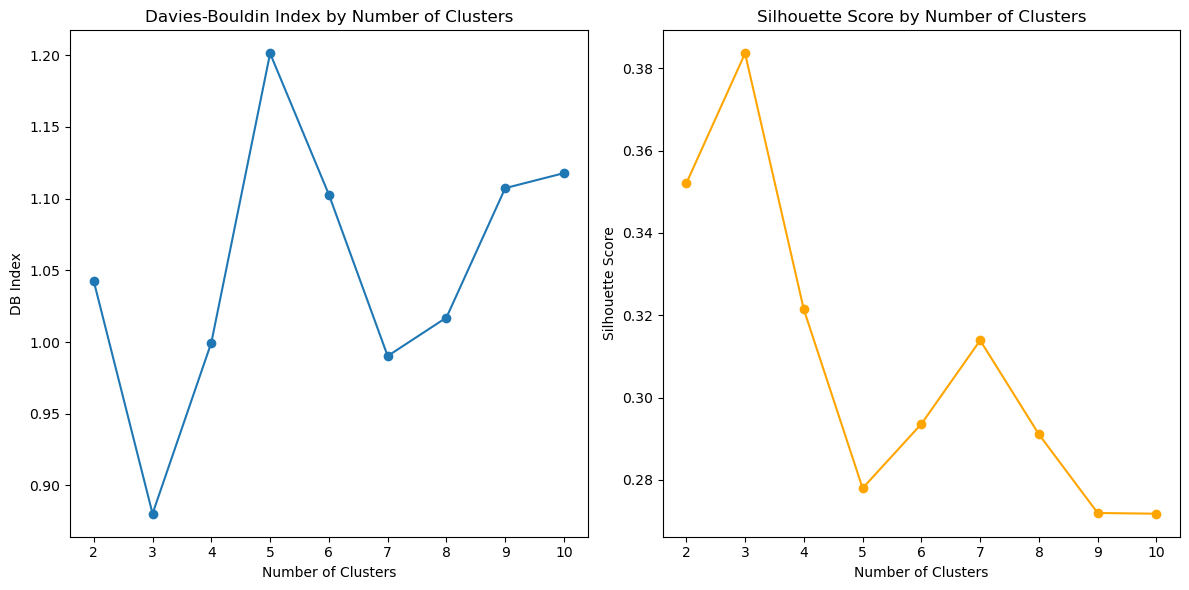

In [21]:
results_df = pd.DataFrame(results, columns=['Number of Clusters', 'DB Index', 'Silhouette Score'])

plt.figure(figsize=(12, 6))

# Plot DB Index
plt.subplot(1, 2, 1)
plt.plot(results_df['Number of Clusters'], results_df['DB Index'], marker='o')
plt.title('Davies-Bouldin Index by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(results_df['Number of Clusters'], results_df['Silhouette Score'], marker='o', color='orange')
plt.title('Silhouette Score by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [22]:
best_n_clusters = results_df.loc[results_df['Silhouette Score'].idxmax(), 'Number of Clusters']
print(f'Best Number of Clusters based on Silhouette Score: {best_n_clusters}')

kmeans_final = KMeans(n_clusters=int(best_n_clusters), random_state=42)
customer_profile['Final Cluster'] = kmeans_final.fit_predict(scaled_features)

Best Number of Clusters based on Silhouette Score: 3


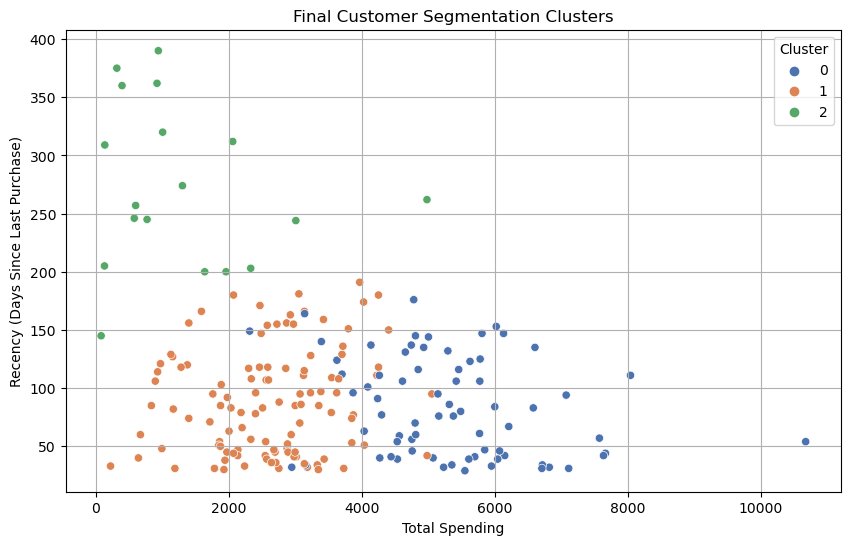

In [23]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_profile, x='Total_Spending', y='Recency', hue='Final Cluster', palette='deep')
plt.title('Final Customer Segmentation Clusters')
plt.xlabel('Total Spending')
plt.ylabel('Recency (Days Since Last Purchase)')
plt.legend(title='Cluster')
plt.grid()
plt.show()